In [1]:
train_csv_path = '/content/drive/MyDrive/ML/lstm_timeseries_glucose/brist1d/train.csv'
test_csv_path = '/content/drive/MyDrive/ML/lstm_timeseries_glucose/brist1d/test.csv'
sub_csv_path = '/content/drive/MyDrive/ML/lstm_timeseries_glucose/brist1d/sample_submission.csv'

In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [3]:
df_train = pd.read_csv(train_csv_path, header=0, index_col=0)

<ipython-input-3-14ba99d5f92b>:1: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(train_csv_path, header=0, index_col=0)


# Multivariate LSTM

## Pre-processing

In [4]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

X_bg = imputer.fit_transform(df_train.filter(like='bg-'))

X_insulin = imputer.fit_transform(df_train.filter(like='insulin'))

X_cals = imputer.fit_transform(df_train.filter(like='cals'))

X_hr = imputer.fit_transform(df_train.filter(like='hr'))

X_time = df_train.filter(like='time')
X_time['time'] = pd.to_datetime(X_time['time'], format='%H:%M:%S')
X_time['time'] = X_time['time'].dt.hour * 60 + X_time['time'].dt.minute
X_time = imputer.fit_transform(X_time)

X = np.hstack((X_bg, X_insulin, X_cals))


y = df_train.iloc[:, -1:].values.flatten() # bg+1:00


X.shape, y.shape

<ipython-input-4-8a6acd6c9863>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_time['time'] = pd.to_datetime(X_time['time'], format='%H:%M:%S')
<ipython-input-4-8a6acd6c9863>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_time['time'] = X_time['time'].dt.hour * 60 + X_time['time'].dt.minute


((177024, 216), (177024,))

In [5]:
TRAIN = 140000
VAL = 20000
X_train, y_train = X[:TRAIN], y[:TRAIN]
X_val, y_val = X[TRAIN:TRAIN+VAL], y[TRAIN: TRAIN+VAL]
X_test, y_test = X[TRAIN+VAL:], y[TRAIN+VAL:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((140000, 216), (140000,), (20000, 216), (20000,), (17024, 216), (17024,))

In [6]:
X_train = X_train.reshape(140000, 216, 1)
X_val = X_val.reshape(20000, 216, 1)
X_test = X_test.reshape(17024, 216, 1)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((140000, 216, 1),
 (140000,),
 (20000, 216, 1),
 (20000,),
 (17024, 216, 1),
 (17024,))

## Building Model



In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

modelm = Sequential()
modelm.add(InputLayer((289, 1)))
modelm.add(LSTM(64))
modelm.add(Dense(8, 'relu'))
modelm.add(Dense(1, 'linear'))

modelm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
cp = ModelCheckpoint('modelm.keras', save_best_only=True)
modelm.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

## Training and Evaluating Model

In [11]:
modelm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, callbacks=[cp])

Epoch 1/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - loss: 10.0380 - root_mean_squared_error: 3.1493 - val_loss: 6.8978 - val_root_mean_squared_error: 2.6264
Epoch 2/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - loss: 6.1059 - root_mean_squared_error: 2.4678 - val_loss: 4.8161 - val_root_mean_squared_error: 2.1946
Epoch 3/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - loss: 4.7446 - root_mean_squared_error: 2.1781 - val_loss: 4.6769 - val_root_mean_squared_error: 2.1626
Epoch 4/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - loss: 4.5361 - root_mean_squared_error: 2.1297 - val_loss: 4.1486 - val_root_mean_squared_error: 2.0368
Epoch 5/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 85s 11ms/step - loss: 4.3993 - root_mean_squared_error: 2.0973 - val_loss: 4.1677 - val_root_mean_squared_error: 2.0415
Epoch 6/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 78s 10ms/step - loss: 4.3340 - root_mean_squared_error: 2.0818 - val_loss: 4.2488 - val_root_mean_squared_error: 2.0613
Epoch 7/15
4375/4375 ━━━━━━

In [12]:
from tensorflow.keras.models import load_model
modelm = load_model('modelm.keras')

In [13]:
train_predictions = modelm.predict(X_train)

4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step


In [14]:
train_actual = y_train.flatten()
train_predictions = train_predictions.flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':train_actual})
train_results

,Train Predictions,Actuals
0,12.553452,13.4
1,12.363573,12.8
2,12.286648,15.5
3,12.855132,14.8
4,12.016390,12.7
...,...,...
139995,9.862899,10.0
139996,10.267101,10.8
139997,10.740847,10.5
139998,10.418249,10.0


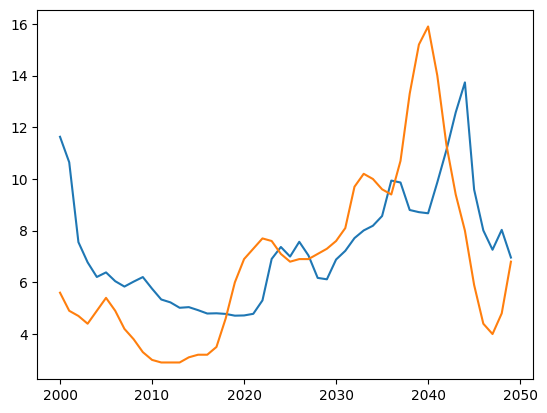

In [16]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][2000:2050])
plt.plot(train_results['Actuals'][2000:2050])

# XGBoost

## Pre-processing

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
# X2 = imputer.fit_transform(X)
# Z2 = imputer.transform(Z.values)

X_bg = imputer.fit_transform(df_train.filter(like='bg-'))

X_insulin = imputer.fit_transform(df_train.filter(like='insulin'))

X_cals = imputer.fit_transform(df_train.filter(like='cals'))

X_hr = imputer.fit_transform(df_train.filter(like='hr'))

X_time = df_train.filter(like='time')
X_time['time'] = pd.to_datetime(X_time['time'], format='%H:%M:%S')
X_time['time'] = X_time['time'].dt.hour * 60 + X_time['time'].dt.minute
X_time = imputer.fit_transform(X_time)

X = np.hstack((X_bg, X_insulin, X_cals))


y = df_train.iloc[:, -1:].values.flatten() # bg+1:00


X.shape, y.shape

<ipython-input-15-2a0eacb19d2f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_time['time'] = pd.to_datetime(X_time['time'], format='%H:%M:%S')
<ipython-input-15-2a0eacb19d2f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_time['time'] = X_time['time'].dt.hour * 60 + X_time['time'].dt.minute


((177024, 216), (177024,))

In [ ]:
TRAIN = 140000
VAL = 20000
X_train, y_train = X[:TRAIN], y[:TRAIN]
X_val, y_val = X[TRAIN:TRAIN+VAL], y[TRAIN: TRAIN+VAL]
X_test, y_test = X[TRAIN+VAL:], y[TRAIN+VAL:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((140000, 216), (140000,), (20000, 216), (20000,), (17024, 216), (17024,))

## Building, training and evaluating model

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 5,
    'subsample': 0.8
}

modelx = xgb.train(params, train_data, num_boost_round=100)

y_pred = modelx.predict(test_data)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')



Mean Squared Error: 3.019579756187921


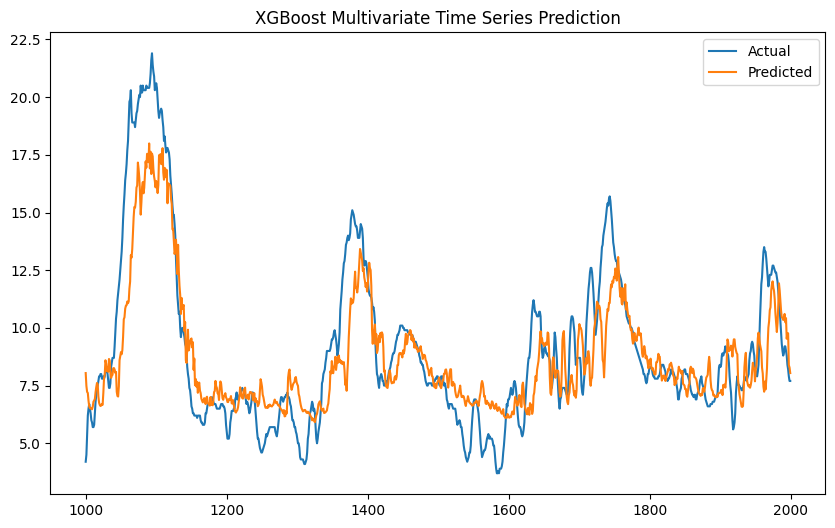

In [ ]:
import matplotlib.pyplot as plt

y_test = pd.DataFrame(y_test)
y_pred = pd.DataFrame(y_pred)

plt.figure(figsize=(10, 6))

range1, range2 = 1000, 2000
plt.plot(y_test.index[range1:range2], y_test[range1:range2], label='Actual')
plt.plot(y_test.index[range1:range2], y_pred[range1:range2], label='Predicted')
plt.legend()
plt.title('XGBoost Multivariate Time Series Prediction')
plt.show()